In [1]:
import numpy as np
import sklearn as skl
import csv
import nltk
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Reading of the information matrix

node_inf_raw = pd.read_csv("./node_information.csv")
node_inf = node_inf_raw.values
for i in range(len(node_inf)):
    if type(node_inf[i][3]) == float:
        node_inf[i][3] = set()
    else:
        node_inf[i][3] = set(node_inf[i][3].split(", "))
    
    if type(node_inf[i][4]) == float:
        node_inf[i][4] = ''

In [3]:
train_raw = np.array(pd.read_csv("./paul_my_train.csv").values)

In [4]:
import networkx as nx

In [5]:
graph = nx.Graph()

In [6]:
for a in node_inf:
    graph.add_node(a[0])

In [7]:
for a in train_raw:
    if a[2] == 1:
        graph.add_edge(a[0], a[1])

In [8]:
maxdeg = 0

for i in graph.nodes:
    if graph.degree(i) > maxdeg:
        maxdeg = graph.degree(i)

In [9]:
print("Le degré max est:",maxdeg)

Le degré max est: 1871


In [10]:
print("Il y a ",len(list(nx.connected_components(graph))), "composantes connexes.")

Il y a  636 composantes connexes.


In [12]:
nx.has_path(graph, 1001, 1002)

True

In [14]:
nx.shortest_path_length(graph, 1001, 1002)

3

In [15]:
test = np.array(pd.read_csv("./paul_my_test.csv").values)

In [17]:
test[:10]

array([[ 206062,  205067,       1],
       [ 202039,  112255,       0],
       [9810163, 9306137,       0],
       [  11290,   10014,       1],
       [ 208112, 9305025,       0],
       [9905180, 9706096,       1],
       [9911149, 9608024,       1],
       [  10190,    6240,       1],
       [9810099, 9810072,       1],
       [9905212, 9903056,       1]])

In [18]:
for a in test[:10]:
    print(nx.shortest_path_length(graph,a[0],a[1]))

2
4
5
2
3
3
2
2
2
2


In [20]:
for a in test[:10]:
    print(graph.degree(a[0])+graph.degree(a[1]))

157
30
13
53
66
76
353
149
237
52


In [24]:
data_test = np.array([[nx.shortest_path_length(graph,a[0],a[1]) if nx.has_path(graph, a[0], a[1]) else -1, graph.degree(a[0])+graph.degree(a[1])] for a in test])


In [28]:
data_test

array([[  2, 157],
       [  4,  30],
       [  5,  13],
       ...,
       [  4,  32],
       [  6,   7],
       [  2, 300]])

In [37]:
sum(test[data_test[:,0]==-1][:,2]==1)/len(test[data_test[:,0]==-1][:,2])

0.11568123393316196

In [29]:
max(data_test[:, 0])

14

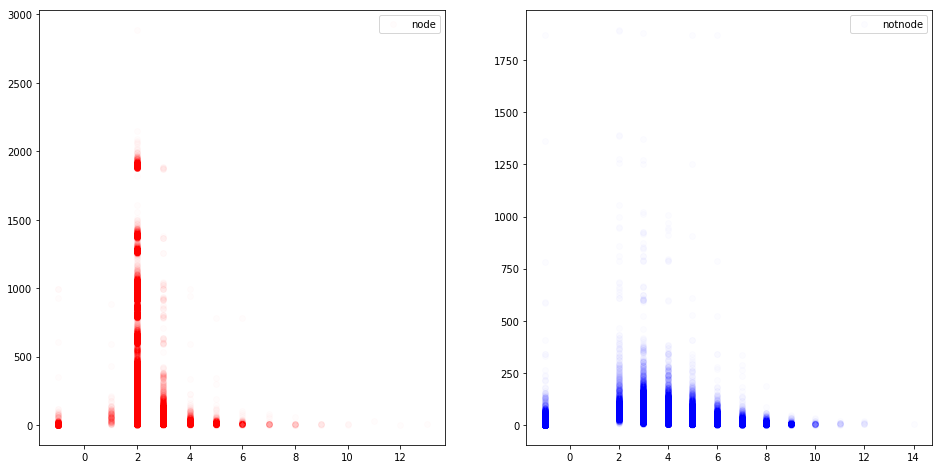

In [55]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.scatter(data_test[test[:,2]==1][:,0], data_test[test[:,2]==1][:,1], label="node", alpha=0.01, c="r")
plt.legend()
plt.subplot(122)
plt.scatter(data_test[test[:,2]==0][:,0], data_test[test[:,2]==0][:,1], label="notnode", alpha=0.01, c="b")
plt.legend()
plt.show()

In [57]:
data_train = []

for a in train_raw:
    if a[2] == 1:
        graph.remove_edge(a[0], a[1])
    data_train.append([nx.shortest_path_length(graph,a[0],a[1]) if nx.has_path(graph, a[0], a[1]) else -1,
                       graph.degree(a[0])+graph.degree(a[1])])
    if a[2] ==1:
        graph.add_edge(a[0], a[1])

data_train = np.array(data_train)

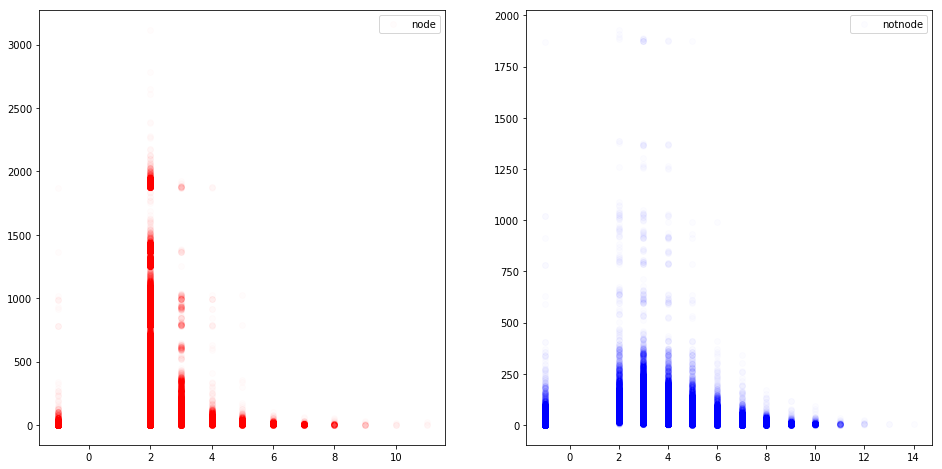

In [70]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.scatter(data_train[train_raw[:,2]==1][:,0], data_train[train_raw[:,2]==1][:,1], label="node", alpha=0.01, c="r")
plt.legend()
plt.subplot(122)
plt.scatter(data_train[train_raw[:,2]==0][:,0], data_train[train_raw[:,2]==0][:,1], label="notnode", alpha=0.01, c="b")
plt.legend()
plt.show()

In [72]:
with open("./paul_train_graph.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["dist", "sum_deg"])
    for a in data_train:
        writer.writerow(a)

In [73]:
with open("./paul_test_graph.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["dist", "sum_deg"])
    for a in data_test:
        writer.writerow(a)

In [75]:
kaggle = np.array(pd.read_csv("./testing_set.txt", delimiter=" ", header=None))

print(kaggle)

data_kaggle = np.array([[nx.shortest_path_length(graph,a[0],a[1]) if nx.has_path(graph, a[0], a[1]) else -1,
                       graph.degree(a[0])+graph.degree(a[1])] for a in kaggle])

[[9807076 9807139]
 [ 109162    1182]
 [9702187 9510135]
 ...
 [9608095 9205058]
 [9407008  106256]
 [ 208144    7142]]


In [76]:
with open("./paul_kaggle_graph.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["dist", "sum_deg"])
    for a in data_kaggle:
        writer.writerow(a)